In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = '/content/drive/MyDrive/dataset'

with_mask_path = os.path.join(base_dir, 'with_mask')
without_mask_path = os.path.join(base_dir, 'without_mask')

with_mask_files = os.listdir(with_mask_path)
without_mask_files = os.listdir(without_mask_path)

In [4]:
print('Number of with mask images:', len(with_mask_files))
print('Number of without mask images:', len(without_mask_files))

Number of with mask images: 1915
Number of without mask images: 1918


In [5]:
with_mask_labels = [1] * len(with_mask_files)
without_mask_labels = [0] * len(without_mask_files)
labels = with_mask_labels + without_mask_labels

In [6]:
data = []

for img_file in with_mask_files:
    image = Image.open(os.path.join(with_mask_path, img_file))
    image = image.resize((128,128))
    image = image.convert('RGB')
    image = np.array(image)
    data.append(image)

for img_file in without_mask_files:
    image = Image.open(os.path.join(without_mask_path, img_file))
    image = image.resize((128,128))
    image = image.convert('RGB')
    image = np.array(image)
    data.append(image)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
X = np.array(data)
Y = np.array(labels)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

num_of_classes = 2

In [9]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_of_classes, activation='softmax')
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=5)

loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 826ms/step - acc: 0.6681 - loss: 0.7473 - val_acc: 0.9121 - val_loss: 0.1967
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 77s 775ms/step - acc: 0.9266 - loss: 0.2246 - val_acc: 0.9121 - val_loss: 0.2298
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 85s 812ms/step - acc: 0.9346 - loss: 0.2011 - val_acc: 0.9251 - val_loss: 0.1752
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 819ms/step - acc: 0.9560 - loss: 0.1327 - val_acc: 0.9511 - val_loss: 0.1505
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 783ms/step - acc: 0.9635 - loss: 0.1119 - val_acc: 0.9642 - val_loss: 0.1117
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - acc: 0.9658 - loss: 0.0978
Test Accuracy = 0.9517601132392883


In [13]:

model.save('mask_prediction_model.keras')
print("✅ Model saved successfully!")

✅ Model saved successfully!


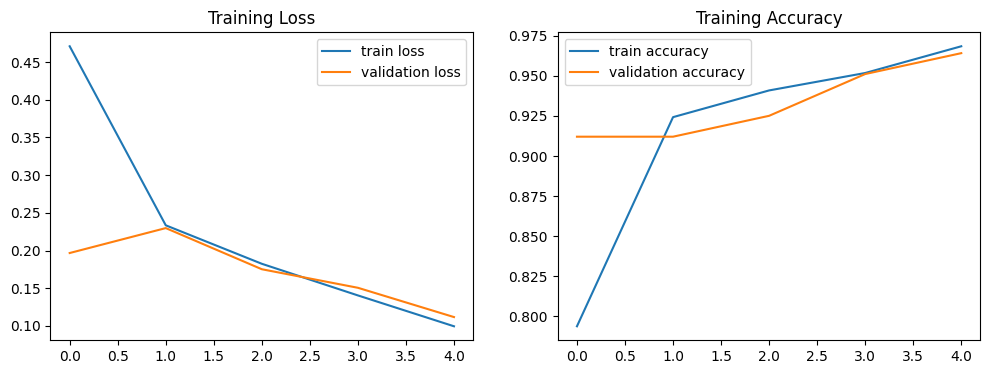

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

In [18]:
def predict_mask(image_path):

    input_image = cv2.imread(image_path)

    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    plt.imshow(input_image_rgb)
    plt.axis('off')
    plt.show()

    input_image_resized = cv2.resize(input_image_rgb, (128,128))
    input_image_scaled = input_image_resized / 255

    input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

    input_prediction = model.predict(input_image_reshaped)
    input_pred_label = np.argmax(input_prediction)

    if input_pred_label == 1:
        print("The person is wearing a mask")
    else:
        print("The person is NOT wearing a mask")

In [ ]:
while True:
    try:
        image_path = input('\nEnter path of the image to predict (or "q" to quit): ')
        if image_path.lower() == 'q':
            break
        predict_mask(image_path)
    except Exception as e:
        print(f"Error processing image: {e}")
